This will plot and compare the resulting data. To run this, make sure that you have already generated all data you want to be compared. For instructions on how to run the generation, see README-new.md

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import numpy as np

from cloudmesh.common.Shell import Shell
from cloudmesh.common.parameter import Parameter
from cloudmesh.common.dotdict import dotdict

from cloudmesh.common.util import banner
from analysis import get_data, read_log, generate_df
pd.options.mode.chained_assignment = None 


In [ ]:
# sizes = [100,1000,5000,10000,50000,100000,500000,1000000,5000000,10000000]

In [3]:
df = generate_df()

In [4]:
df

,p,size,repeat,sort,user,node,t,c,time
0,21,5000000,10,mp,alex,v100,None,None,10.880
1,21,5000000,10,mp,alex,v100,None,None,10.459
2,21,5000000,10,mp,alex,v100,None,None,10.650
3,21,5000000,10,mp,alex,v100,None,None,10.412
4,21,5000000,10,mp,alex,v100,None,None,10.265
...,...,...,...,...,...,...,...,...,...
3345,8,500000,10,mpi,alex,v100,None,None,3.687
3346,8,500000,10,mpi,alex,v100,None,None,3.576
3347,8,500000,10,mpi,alex,v100,None,None,3.722
3348,8,500000,10,mpi,alex,v100,None,None,3.710


In [5]:
def average_df(df):
    _df = df.groupby(['p','size','repeat','sort','user','node','t','c'], sort=True, as_index=False).agg({'time':'mean'})
    _df.reset_index()
    return _df

In [6]:
index_max_size = df[(df['size'] == 50000000) | (df['size'] == 500)].index
df.drop(index_max_size, inplace=True)

In [7]:
df = average_df(df)
print(df.to_string())

      p      size  repeat sort  user  node     t     c     time
0     1       100      10   mp  alex  v100  None  None   0.0150
1     1       100      10  seq  alex  v100  None  None   0.0006
2     1      1000      10   mp  alex  v100  None  None   0.0206
3     1      1000      10  seq  alex  v100  None  None   0.0055
4     1      5000      10   mp  alex  v100  None  None   0.0622
5     1      5000      10  seq  alex  v100  None  None   0.0269
6     1     10000      10   mp  alex  v100  None  None   0.0939
7     1     10000      10  seq  alex  v100  None  None   0.0563
8     1     50000      10   mp  alex  v100  None  None   0.3858
9     1     50000      10  seq  alex  v100  None  None   0.2859
10    1    100000      10   mp  alex  v100  None  None   0.7636
11    1    100000      10  seq  alex  v100  None  None   0.5455
12    1    500000      10   mp  alex  v100  None  None   3.4632
13    1    500000      10  seq  alex  v100  None  None   3.1286
14    1   1000000      10   mp  alex  v1

In [8]:
def calculate_speedup(df):
    frames = []
    gb = df.groupby(['size','repeat','user','node','t','c'])
    for x in gb.groups:
        _df = gb.get_group(x)
        seq_time = _df[_df['sort'] == 'seq'].iat[0, 8]
        # print(seq_time)
        scale = 1 / seq_time
        # print(scale)
        
        _df['speedup'] = _df['time'].rdiv(seq_time)
        frames.append(_df)
    ans = pd.concat(frames)
    return ans

In [9]:
def calculate_efficiency(df):
    ans = calculate_speedup(df)
    ans['efficiency'] = ans['speedup'] / ans['p']
    return ans

In [18]:
def calculate_strong_speedup(df):
    prop_mp = 0.80 # time proportion of multiprocessing merge sort that can be parallelized
    prop_mpi = 0.90 # time proportion of MPI merge sort that can be parallelized
    conditions = [
        (df['sort'] == 'seq'),
        (df['sort'] == 'mp'),
        (df['sort'] == 'mpi')
    ]

    values = [1, prop_mp, prop_mpi]

    df['prop'] = np.select(conditions, values)
    df['strong_speedup'] = 1 / ((1 - df['prop']) + (df['prop'] / df['p']))
    df = df.drop(columns=['prop'])
    return df


In [19]:
df = calculate_speedup(df)
df = calculate_strong_speedup(df)

In [20]:
def plot_benchmark(df, x_axis, y_axis, hue, bound=None, tag=None):
    hues = df[hue].unique()
    hues = [str(hue) for hue in hues]
    # name the image
    hues_name = "-".join(hues)
    name = f"{y_axis}-by-{x_axis}-{hue}"
    sns.lineplot(data=df, x=x_axis, y=y_axis, hue=hue)
    if bound != None:
        sns.lineplot(data=df, x=x_axis, y=bound, hue=hue)
    plt.title(name)
    plt.savefig(f"images/{name}.png")
    plt.savefig(f"images/{name}.pdf")

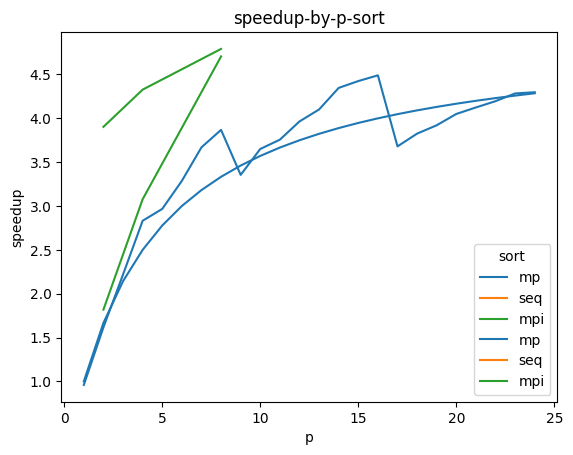

In [21]:
plot_benchmark(df, 'p', 'speedup', 'sort', bound='strong_speedup')

In [15]:
def get_values(df, processes, sizes, sorts, users, nodes):
    _df = df[df['p'].isin(processes) & df['size'].isin(sizes) & df['sort'].isin(sorts) & df['user'].isin(users) & df['node'].isin(nodes)]
    return _df

In [16]:
df = get_values(df, list(range(1,30)), [10000000], ["mp","mpi","seq"], ["alex"], ["v100"])

In [ ]:
df

In [ ]:
plot_benchmark(df, 'p', 'time', 'sort')